<a href="https://colab.research.google.com/github/habhishek/nlp_samples/blob/main/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load the dependencies

In [1]:

import tensorflow
from tensorflow.keras.datasets import imdb # new! 
from tensorflow.keras.preprocessing.sequence import pad_sequences #new!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding # new!
from tensorflow.keras.callbacks import ModelCheckpoint # new! 
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
import pandas as pd
import matplotlib.pyplot as plt

#### Set Hyperparamters

In [2]:
output_dir = 'model_output/dense'

# training
epochs = 4
batch_size = 128

# vector-space embedding
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011)
n_words_to_skip = 50 # assume - the 50 most frequently occuring words will be
                     # stopwords
max_review_length = 100
pad_type = trunc_type = 'pre'

# neural network architecture
n_dense = 64
dropout = 0.5

#### Load Data


For a given data set:

* The TensorFlow Keras module's text utilities [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text) quickly preprocess natural language and convert it into an index

* The Tokenizer class covered therein may do everything you need in a single line of code:
** tokenize into words or characters
** num_words: maximum unique tokens
** filter out punctuation
** lower case
** convert words to an integer index

* Other natural language preprocessing steps you may want to consider for your particular dataset and application are covered in the Natural Language Preprocessing notebook, including:
** removing stop words
** either stemming or lemmatization
** colocating n-grams, such as bigrams and trigrams

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words,
                                                        skip_top=n_words_to_skip)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [4]:
x_train[0:6] # 0 reserverd for padding; 1 would be starting character; since we
# skip the 50 most common words, they are converted into unknown tokens represented by 2
# first actual word is represented by 3 - most frequently occuring

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [5]:
for x in x_train[0:6]:
  print(len(x))

218
189
141
550
147
43


In [6]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [7]:
print(len(x_train), len(x_valid))

25000 25000


#### Restoring words from index

In [8]:
word_index = tensorflow.keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

In [ ]:
word_index

In [10]:
index_word = {v:k for k,v in word_index.items()}

In [ ]:
x_train[0]

In [12]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [13]:
# to compare data which has all the frequently occuring words
(all_x_train, _), (all_x_valid, _) = imdb.load_data()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [14]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Preprocess data

In [15]:
x_train = pad_sequences(x_train, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length,
                        padding=pad_type, truncating=trunc_type, value=0)

In [25]:
len(x_train)

25000

#### Design neural network architecture

In [16]:
model = Sequential()

# first hidden layer:
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())

# second hidden layer:
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))

# output_layer
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax
                                           # with 2 classes

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                409664    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [18]:
# embedding layer dimensions and parameters:
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [19]:
# flatten:
max_review_length, n_dim, n_dim*max_review_length

(100, 64, 6400)

In [20]:
# ...dense:
n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases

(64, 409664)

#### Configure Model


In [21]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [23]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

#### Train

In [24]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 4s 17ms/step - loss: 0.5541 - accuracy: 0.6947 - val_loss: 0.3600 - val_accuracy: 0.8395
Epoch 2/4
196/196 [==============================] - 3s 15ms/step - loss: 0.2866 - accuracy: 0.8845 - val_loss: 0.3473 - val_accuracy: 0.8470
Epoch 3/4
196/196 [==============================] - 3s 16ms/step - loss: 0.1212 - accuracy: 0.9631 - val_loss: 0.4250 - val_accuracy: 0.8331
Epoch 4/4
196/196 [==============================] - 3s 15ms/step - loss: 0.0294 - accuracy: 0.9950 - val_loss: 0.5296 - val_accuracy: 0.8275


In [26]:
model.load_weights(output_dir+"/weights.01.hdf5")

In [27]:
y_hat = model.predict_proba(x_valid)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [28]:
len(y_hat)

25000

In [29]:
y_hat[0], y_valid[0]

(array([0.71795315], dtype=float32), 0)

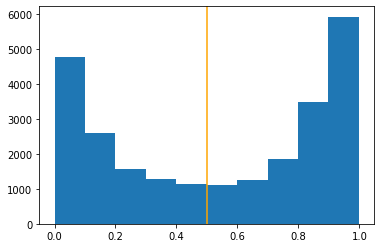

In [30]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [31]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [32]:
pct_auc

92.404744

In [34]:
y_hat[0][0]

0.71795315

In [35]:
float_y_hat = []
for y in y_hat:
  float_y_hat.append(y[0])

In [36]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [38]:
ydf.head(20)

,y_hat,y
0,0.717953,0
1,0.919630,1
2,0.771239,1
3,0.276946,0
4,0.975027,1
5,0.791645,1
6,0.893077,1
7,0.066053,0
8,0.875327,0
9,0.734749,1


In [39]:
' '.join(index_word[id] for id in all_x_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [40]:
# try to filter the false positives

ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
256,0.934687,0
386,0.907679,0
447,0.921434,0
680,0.914536,0
740,0.942515,0
781,0.921765,0
810,0.928647,0
921,0.927948,0
999,0.907894,0
1059,0.941230,0
